In [ ]:
!pip install transformers
!pip install sumeval
!pip install py7zr

# Decription 
### Fine-Tune a T5 model on the samsum dataset using Pytorch and HugingFace.

In [5]:
import gc
import random
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sumeval.metrics.rouge import RougeCalculator

import torch
from transformers import AutoTokenizer
import transformers
from transformers import AutoModelForSeq2SeqLM
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os

print('Pytorch version: %s'  % torch.__version__)

Pytorch version: 1.11.0


In [6]:
warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', 100)
cuda =  torch.cuda.is_available()
device = torch.device("cuda") if cuda else torch.device("cpu")

## Reading Data

In [7]:
from datasets import load_dataset
dataset = load_dataset("samsum")

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
train = dataset["train"]
valid = dataset["validation"]
test = dataset["test"]

train = train.remove_columns(["id"])
valid = valid.remove_columns(["id"])
test = test.remove_columns(["id"])

print(len(train), len(valid), len(test))
print("dataset has features: ", train)
print("sample input and output is")
print(train[0]["dialogue"])
print(train[0]["summary"])

14732 818 819
dataset has features:  Dataset({
    features: ['dialogue', 'summary'],
    num_rows: 14732
})
sample input and output is
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Amanda baked cookies and will bring Jerry some tomorrow.


## Data Analysis

In [9]:
# analyze input and summary lengths
dialogue_lengths = [len(text.split()) for text in train["dialogue"]]
summary_lengths = [len(text.split()) for text in train["summary"]]
print("average length of dialogue is", sum(dialogue_lengths)/len(dialogue_lengths))
print("average length of summary is", sum(summary_lengths)/len(summary_lengths))

average length of dialogue is 93.7863833831116
average length of summary is 20.3174721694271


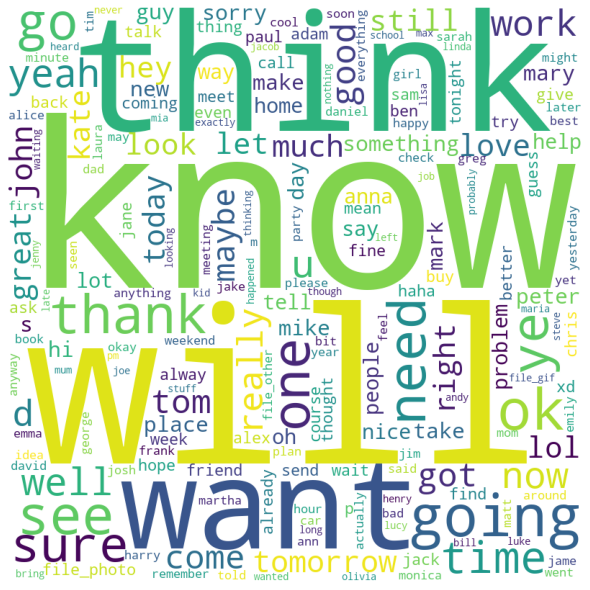

In [10]:
comment_words = ''
stopwords = set(STOPWORDS)
 
for text in train["dialogue"]:
    tokens = text.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "

for text in train["summary"]:
    tokens = text.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Modeling

In [11]:
# t5-small = 60M parameters
# t5-base = 220M parameters
# t5-large = 770M parameters
# t5-3b = 3 billion
# t5-11b = 11 billion
# Loading tokenizer of t5 model
tokenizer = AutoTokenizer.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [12]:
# prompting the model to do summarisation
prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
    model_inputs["input_ids"] = model_inputs["input_ids"]

    labels = tokenizer(text=examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [13]:
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_valid = valid.map(preprocess_function, batched=True)
tokenized_test = test.map(preprocess_function, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [14]:
tokenized_train = tokenized_train.remove_columns(["dialogue"]).remove_columns(["summary"]).remove_columns(["attention_mask"])
tokenized_valid = tokenized_valid.remove_columns(["dialogue"]).remove_columns(["summary"]).remove_columns(["attention_mask"])
tokenized_test = tokenized_test.remove_columns(["dialogue"]).remove_columns(["summary"]).remove_columns(["attention_mask"])

tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")
tokenized_test.set_format("torch")

print("data format now is", tokenized_train)

data format now is Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 14732
})


## Loading the model

In [15]:
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")  # has 60M parameters

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

In [16]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataloader import default_collate

def pad_collate(batch):
    xx = [x["input_ids"] for x in batch]
    yy = [x["labels"] for x in batch]
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)
    
    data = [{"input_ids": x, "labels": y} for x,y in zip(xx_pad, yy_pad)]
    
    return default_collate(data)

train_dataloader = DataLoader(tokenized_train, shuffle=True, batch_size=8, collate_fn=pad_collate)
eval_dataloader = DataLoader(tokenized_valid, batch_size=8, collate_fn=pad_collate)

In [17]:
from transformers import get_scheduler
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5.6e-5, weight_decay=0.01)

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
print("Training steps are", num_training_steps)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

Training steps are 18420


In [18]:
rouge = RougeCalculator(stopwords=True, lang="en")

def rouge_calc(preds, targets):
    rouge_1 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=1) for i in range(len(preds))]
    rouge_2 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=2) for i in range(len(preds))]
    rouge_l = [rouge.rouge_l(summary=preds[i],references=targets[i]) for i in range(len(preds))]

    return {"Rouge_1": np.array(rouge_1).mean(),
            "Rouge_2": np.array(rouge_2).mean(),
            "Rouge_L": np.array(rouge_l).mean()}

def evaluate(model, eval_dataloader, tokenizer):
    prediction = []
    ground_truth = []
    losses = []
    for eval_batch in eval_dataloader:
        eval_batch = {k: v.to(device) for k, v in eval_batch.items()}
        outputs = model.generate(eval_batch['input_ids'])
        losses.append(model(**eval_batch).loss.item())
        for i in range(0,len(eval_batch)):
            prediction.append(tokenizer.decode(outputs[i], skip_special_tokens=True))
            ground_truth.append(tokenizer.decode(eval_batch['labels'][i], skip_special_tokens=True))

    scores = rouge_calc(prediction , ground_truth)
    avg_loss = sum(losses)/len(losses)
    print("Validation data score and losses are", scores, avg_loss)
    return avg_loss

In [19]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
OUT_DIR = "/kaggle/working/"

model.to(device)

step = 0
last_loss = 1000
for epoch in range(num_epochs):
    for batch in train_dataloader:
        model.train()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
        # evaluate on every 400th step
        if step % 400 == 0:
            model.eval()
            print("Train loss on {}th step is {}".format(step, loss.item()))
            loss = evaluate(model, eval_dataloader, tokenizer)
            if loss < last_loss: # save model parameters
                checkpoint_path = OUT_DIR + "best_checkpoint/"
                if not os.path.exists(checkpoint_path):
                    os.makedirs(checkpoint_path)
                model.save_pretrained(checkpoint_path)
                tokenizer.save_pretrained(checkpoint_path)
                torch.save(optimizer.state_dict(), os.path.join(checkpoint_path, "optimizer.pt"))
                torch.save(lr_scheduler.state_dict(), os.path.join(checkpoint_path, "scheduler.pt"))
                #torch.save(args, os.path.join(args.output_dir, "training_args.bin"))
                last_loss = loss
        step += 1
# save the last model weights
model.save_pretrained(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)
torch.save(optimizer.state_dict(), os.path.join(OUT_DIR, "optimizer.pt"))
torch.save(lr_scheduler.state_dict(), os.path.join(OUT_DIR, "scheduler.pt"))

  0%|          | 0/18420 [00:00<?, ?it/s]

Train loss on 0th step is 2.7449569702148438
Validation data score and losses are {'Rouge_1': 0.31644616939082004, 'Rouge_2': 0.07276257684079979, 'Rouge_L': 0.2766890183947161} 2.3940305732986302
Train loss on 400th step is 1.2059465646743774
Validation data score and losses are {'Rouge_1': 0.43440155391558855, 'Rouge_2': 0.1509919179576475, 'Rouge_L': 0.37797890679021756} 1.08122423551615
Train loss on 800th step is 1.3883628845214844
Validation data score and losses are {'Rouge_1': 0.4271514262259575, 'Rouge_2': 0.14652779031162028, 'Rouge_L': 0.37299715202996747} 1.0363795057083796
Train loss on 1200th step is 1.0975662469863892
Validation data score and losses are {'Rouge_1': 0.44741142340648005, 'Rouge_2': 0.164921118314119, 'Rouge_L': 0.3906052861426254} 1.012645652571928
Train loss on 1600th step is 0.7793858647346497
Validation data score and losses are {'Rouge_1': 0.4470750381444126, 'Rouge_2': 0.17891065761684335, 'Rouge_L': 0.3955484727012163} 0.9955918673172738
Train loss 

## Make some predictions

In [22]:
# load the pre-trained best-checkpoint model
tokenizer = tokenizer.from_pretrained(OUT_DIR + "best_checkpoint/", do_lower_case=False)
model = model.from_pretrained(OUT_DIR + "best_checkpoint/")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [29]:
batch = next(iter(eval_dataloader))
batch = {k: v.to(device) for k, v in batch.items()}
outputs = model.generate(batch['input_ids'])

print(tokenizer.decode(outputs[6], skip_special_tokens=True))
print(tokenizer.decode(batch['labels'][6], skip_special_tokens=True))
print(tokenizer.decode(batch['input_ids'][6], skip_special_tokens=True))

SHE makes a noise.
Samantha and Evelyn after watching the video cannot believe she is able to make that noise.
summarize: Samantha: file_video> Evelyn: LOL Holly: Is SHE making that noise?? Samatha: Yes () Holly: How possible?? :o Samantha: Idk, I'm also surprised!! Evelyn: xD
